In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt


In [8]:
class Network:
    def __init__(self, eta, layers, max_i=10000, max_error=0.01, batch_size=20):
        self._eta = eta
        self._layers = layers
        self._w = []
        self._y = []
        self._delta = []
        self.max_i = max_i
        self.max_error = max_error
        self.batch_size = batch_size

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def _create_weights(self, x_num):
        for i, layer_i in enumerate(self._layers):
            if i == 0:
                self._w.append(
                    np.random.uniform(-1, 1, size=(layer_i, x_num + 1)))
            else:
                self._w.append(
                    np.random.uniform(
                        -1, 1, size=(layer_i, self._w[i - 1].shape[0] + 1)
                    )
                )
            self._y.append(np.zeros(layer_i))
            self._delta.append(np.zeros(layer_i))

    def _forward_progation(self, x):
        x= np.append(np.ones((len(x),1)), x, axis=1)
        for i in range(len(self._layers)):
            if i == 0:
                self._y[i] = np.dot(x,self._w[i].T)
            else:
                self._y[i] = np.dot(np.append(np.ones((len(self._y[i - 1]),1)), self._y[i - 1], axis=1),self._w[i].T)
            self._y[i] = self.sigmoid(self._y[i])


    def _backward_propagation(self, expected_output):
        for i in range(len(self._delta)-1,-1,-1):
            if i == len(self._delta) - 1:
                error = expected_output - self._y[i]
                self._delta[i] = error * self.sigmoid(self._y[i], True)
            else:
                self._delta[i] = np.dot(
                    self._delta[i+1], self._w[i+1][:, 1:]) * self.sigmoid(self._y[i], True)
        return error

    def _update(self, x):
        for i in range(len(self._layers)):
            if i == 0:
                self._w[i]+= np.dot(self._delta[i].T, np.append(np.ones((len(x),1)), x, axis=1)) * self._eta
            else:
                self._w[i] += np.dot(self._delta[i].T, np.append(np.ones((len(self._y[i-1]),1)), self._y[i-1], axis=1)) * self._eta

    def fit(self, x, y, verbose=False):
        self._create_weights(np.shape(x)[1])
        for epoch in range(self.max_i):
            ind = np.random.randint(0,len(x),self.batch_size)
            E = 0
            self._forward_progation(x[ind])
            b = self._backward_propagation(y[ind])
            b = b**2
            E += 0.5 * b.sum()
            self._update(x[ind])
            if verbose:
                print(f"Epoka: {epoch+1} z {self.max_i}, blad: {E}")
        return E

    def predict(self, x):
        self._forward_progation(x)
        return self._y[-1]


In [9]:
def prepare_data(directory):
    data = []
    for file in os.listdir(directory):
        img = Image.open(os.path.join(directory, file))
        img = img.convert('RGB')
        img_box = np.array(img).reshape(3072, 64)
        data.append(img_box)
    return data


In [10]:
data = prepare_data('data/images/in')


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(np.concatenate(data))


In [12]:
network = Network(0.005, (32, 64), 45000, batch_size=45)
network.fit(x, x)


2.753551812560877

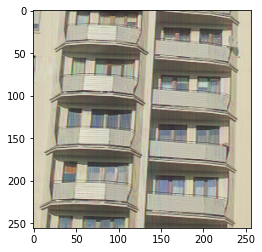

In [13]:
for i, x_test in enumerate(data,1):
    scaler = MinMaxScaler()
    x_test = scaler.fit_transform(x_test)
    result = network.predict(x_test)
    result = scaler.inverse_transform(result)
    img = np.concatenate(result).reshape(256, 256, 3)
    img = img.astype('uint8')
    img = Image.fromarray(img, 'RGB')
    plt.imshow(img)
    img.save(os.path.join('data/images/out',f'img{i}.png'))